In [2]:
import numpy as np
from scipy.integrate import trapz
import matplotlib.pyplot as plt

In [3]:
cluster='Ruprecht_147'
objectid='219652181'
t_start,t_stop,id_start,id_stop,comment=np.loadtxt('share/cross_match/union/'+cluster+'_post_appa/'+objectid+'_my_flares.txt',delimiter=',',unpack=True,dtype=[('t_start', np.float), ('t_stop', np.float), ('id_start', np.int), ('id_stop', np.int), ('comment', 'S32')])
time,flux_gap,error,flux_model=np.loadtxt('share/cross_match/union/'+cluster+'_post_appa/'+objectid+'.txt',delimiter=',',unpack=True)
istart, istop=np.loadtxt('share/cross_match/union/'+cluster+'_post_appa/'+objectid+'_flares.txt',delimiter=',',unpack=True,dtype=np.dtype(np.int16))


In [4]:
def ED(start,stop,time,flux_model,flux_gap):
    time=time[start:stop+1]
    model=flux_model[start:stop+1]
    flux=flux_gap[start:stop+1]
    residual=np.subtract(flux,model)
    flare=trapz(residual,time)
    quiet=trapz(model,time)
    ed=flare/quiet
    return ed


In [5]:
myED=[]

for start, stop in zip(id_start,id_stop):
    ed=ED(start,stop,time,flux_model,flux_gap)
    myED.append(ed)

    
AppaED=[]

for start, stop in zip(istart,istop):
    ed=ED(start,stop,time,flux_model,flux_gap)
    AppaED.append(ed)



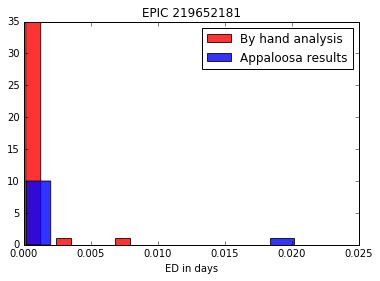

In [6]:

plt.figure()
plt.title('EPIC '+objectid)
plt.hist(myED,len(myED)//5,alpha=0.8,color='red',label='By hand analysis')
plt.hist(AppaED,len(AppaED)//1,alpha=0.8,label='Appaloosa results')
plt.legend()
plt.xlabel('ED in days')
plt.show()
#plt.savefig('results/'+objectid+'_byhand_vs_Appaloosa.png')

- ~~retrieve colors~~
- ~~retrieve distances for cluster~~
- from colors estimate spectral class
- from spectral class use spectrum from Sarah's SpecPhot
- from spectral class use radius from XXX
- use Kepler filter curve to calculate quiescent flux:
- L_∗ = πR^2 ∗int( dλ R_Kepler(λ)* B_SpecPhot(λ))
- Finally: ED*L_*=Kepler energy

In [267]:
params=open('share/cross_match/union/'+cluster+'_parameter.txt')
param_dict=dict()
basics=params.readline()
#print(basics)
basics=[u for u in basics[1:-2].split(', ')]
for line in params:
    s=np.core.defchararray.split(line, sep=",").tolist()
    col=s[3:]
    col=[float(item) for item in col]
    try:
        param_dict[int(s[0])]=[int(s[1]),s[2],col]
    except ValueError:
        param_dict[int(s[0])]=[s[1],s[2],col]
#print(param_dict)

In [280]:
#if band value == -999.0 no magnitude is given

#read in table for spectral class: read in as list [class,lum_class,u-g,g-r,r-i,i-z,z-J,J-H,H-k,Jmag_abs]
#LATER: Add z-y from mamajek or so...
import numpy as np
spec_class,lum_class,ug,gr,ri,iz,zJ,JH,HK,Jmag_abs=np.loadtxt('share/cross_match/union/spectralclasses.csv',skiprows=49,delimiter=',',unpack=True,dtype=[('spec_class','S4'),('lum_class','U3'),('u-g',np.float),('g-r',np.float),('r-i',np.float),('i-z',np.float),('z-J',np.float),('J-H',np.float),('H-K',np.float),('Jmag_abs',np.float)])
spec_class=[x.strip(' ') for x in spec_class]
lum_class=[x.strip(' ') for x in lum_class]
lum_class_I=[i for i,x in enumerate(lum_class) if x=='I']
lum_class_III=[i for i,x in enumerate(lum_class) if x=='III']
lum_class_V=[i for i,x in enumerate(lum_class) if x=='V']

#spec_class_I=[x for i,x in enumerate(spec_class) if i in lum_class_I]
print(lum_class_III)
lookup_spec={'Jmag_abs':Jmag_abs,'V':lum_class_V,'III':lum_class_III,'I':lum_class_I,'class':spec_class,'ug':ug,'gr':gr,'ri':ri,'iz':iz,'zJ':zJ,'jh':JH,'hk':HK}

[36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67]


In [281]:
#calculate distance modulus for cluster
DM = lambda x: 5.*np.log10(float(x))-5. #I used a lambda function!
dm=DM(basics[3])
print(dm)
global dm

7.3856062736


In [290]:
from bisect import bisect_left as binary_search
#
def find_spec_class(lookup_spec,color, index,l='V'):
    try:
        spec_class=lookup_spec['class']
        lum_class=lookup_spec[l]

        color_list=lookup_spec[index]
        i_lam=min(color_list, key=lambda x:abs(x-color))
        i=binary_search(color_list[lum_class],color)-1
        print(i,i_lam)
        return [spec_class[lum_class[i]],l]
    except KeyError:
        return 'no entry'
    
    

In [291]:
#For each obj in dict:
#whatever is available: Calculate color_index i-z (or z-y), J-H in this order

def insert_spec_class(c,lookup_spec,j,h,index):
    if j!=-999.0 and h!=-999.0:
        c[index]=[j-h,find_spec_class(lookup_spec,j-h,index)]
    return 
def insert_lum_class(c,lookup_spec,J,index):
    if J!=-999.0:
        J-=dm
        c[index]=[J,find_spec_class(lookup_spec,J,'Jmag_abs')]
    return 

for key,value in param_dict.items():
    
    if len(value)==4:
        c=value[3]
    else:
        value.append(dict())
        c=value[3]
    if value[1]=='jhkJ':
        j,h,k,J=value[2]
        insert_spec_class(c,lookup_spec,j,h,'jh')
        insert_spec_class(c,lookup_spec,h,k,'hk')
        insert_lum_class(c,lookup_spec,J,'J')
        
    elif value[1]=='grizyJ':
        g,r,i,z,y,J=value[2]
        insert_spec_class(c,lookup_spec,g,r,'gr')
        insert_spec_class(c,lookup_spec,r,i,'ri')
        insert_spec_class(c,lookup_spec,i,z,'iz')
        insert_spec_class(c,lookup_spec,z,y,'zy')
        insert_lum_class(c,lookup_spec,J,'J')

    print(c)
#check with spectral class table. find value in ordered list
#check distance with luminosity class using absolute Jmag_abs and J from param_dict
#add color_index, spec_class to obj#bokeh barplot spectral classes

33 0.76
22 4.5
{'J': [4.3533937264016878, ['K0', 'V']], 'iz': [0.7639999999999993, ['M4', 'V']], 'zy': [0.46199999999999974, 'no entry']}
26 0.54
27 0.34
22 4.17
{'J': [4.2753937264016866, ['K0', 'V']], 'iz': [0.34499999999999886, ['K7', 'V']], 'ri': [0.5159999999999982, ['K5', 'V']]}
35 7.72
{'J': [8.6763937264016882, ['M6', 'V']]}
24 0.89
24 0.32
25 0.18
34 7.72
{'zy': [0.1789999999999985, 'no entry'], 'J': [7.6483937264016877, ['M5', 'V']], 'iz': [0.18400000000000105, ['K4', 'V']], 'gr': [0.8989999999999974, ['K3', 'V']], 'ri': [0.32700000000000173, ['K3', 'V']]}
18 0.28
21 0.05
12 2.43
{'hk': [0.05400000000000027, ['G8', 'V']], 'J': [2.2063937264016875, ['A7', 'V']], 'jh': [0.28200000000000003, ['G0', 'V']]}
15 0.23
26 0.11
12 1.82
{'hk': [0.10699999999999932, ['K5', 'V']], 'J': [1.7923937264016878, ['A7', 'V']], 'jh': [0.22500000000000142, ['F5', 'V']]}
17 0.23
24 0.09
11 1.72
{'hk': [0.09200000000000053, ['K3', 'V']], 'J': [1.7193937264016874, ['A5', 'V']], 'jh': [0.2330000000000

In [289]:
#check with spectral class table. find value in ordered list
